# Module 6. Bivariate analysis of 2 quantitative variables

In this module, we discuss the case where both variables are quantitative. Specifically, we'll explore the concept of *linear regression*. Other analysis methods do exist, but those are beyond the scope of this course.

Regression analysis is an extremely flexible tool that can aid decision
making in many areas. [Kimes and Fitzsimmons (1990)](https://ecommons.cornell.edu/handle/1813/72194) describe how
it has been used by La Quinta Motor Inns, a moderately priced hotel
chain oriented toward serving the business traveler, to help make site
location decisions. 

There are two potential objectives of regression analysis. The first objective is to understand how the world operates, for example, one might try to discover whether there is any
gender discrimination in salaries, taking into account differences in work experience and
education level.  
The second objective is to make predictions. A good example of this is
when the variable in question is company sales, and variables such as advertising and past
sales levels are used as explanatory variables.

In [1]:
# Package imports
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Dataframe
import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Visualization

A good way to begin any regression analysis is to draw one or more scatterplots. If there
is any relationship between the two variables, it is usually apparent from the scatterplot.  
To visualize quantitative data, we can use Seaborn's `relplot()` function. The independent variable should be mapped to the X-axis, the dependent variable to the Y-axis.  
In the example below we will use the Penguins dataset.

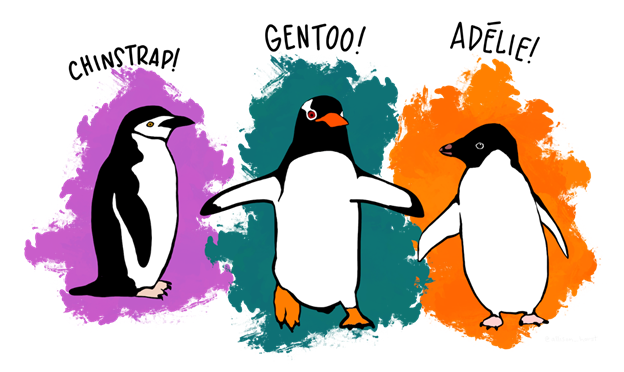

In [2]:
penguins = sns.load_dataset('penguins') # Load the Palmer Penguins demo dataset
penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

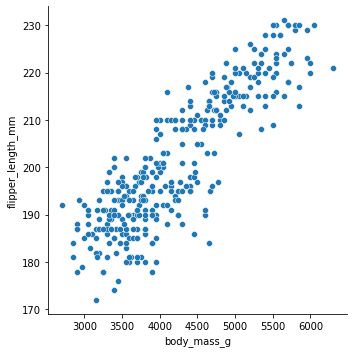

In [3]:
sns.relplot(data=penguins, x='body_mass_g', y='flipper_length_mm')

Using other chart attributes like hue, style, etc. you can also visualize categorical variables in the data set, e.g.:

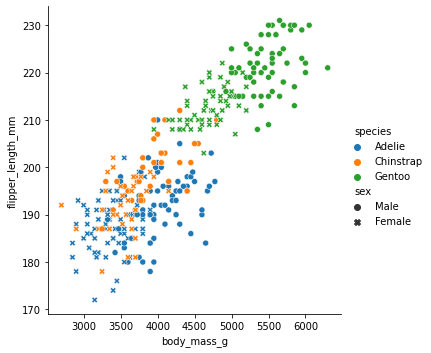

In [4]:
sns.relplot(data=penguins,
            x='body_mass_g', y='flipper_length_mm',
            hue='species', style='sex')

Another example:

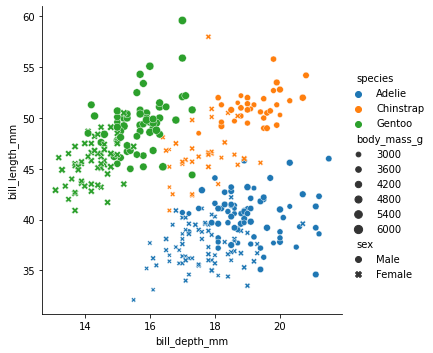

In [5]:
sns.relplot(data=penguins,
            x='bill_depth_mm', y='bill_length_mm',
            size='body_mass_g', 
            hue='species', style='sex')

## Method of Least Squares: Introduction

Scatterplots are very useful for indicating linear relationships and the
strengths of these relationships. But they do not actually quantify the relationships. For
example, it is clear from the scatterplot that body_mass_g is related
to flipper_length_mm. But the scatterplot does not specify exactly what this relationship 
is. If the flipper_length_mm is 190, what would you predict body_mass_g to be?  
To
answer these questions, the relationship between the dependent variable body_mass_g and the
explanatory variable flipper_length_mm must be quantified.  
To reduce the number of points in the scatterplot and make the plots as clear as possible, we are going to take only the male, Chinstrap penguins into account.

In [6]:
male_chinstrap = penguins[(penguins['species'] == 'Chinstrap') & (penguins['sex'] == 'Male')]
male_chinstrap.head()

species island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
153  Chinstrap  Dream            50.0           19.5              196.0   
154  Chinstrap  Dream            51.3           19.2              193.0   
156  Chinstrap  Dream            52.7           19.8              197.0   
159  Chinstrap  Dream            51.3           18.2              197.0   
161  Chinstrap  Dream            51.3           19.9              198.0   

     body_mass_g   sex  
153       3900.0  Male  
154       3650.0  Male  
156       3725.0  Male  
159       3750.0  Male  
161       3700.0  Male

Some male, Chinstrap penguins have the same flipper_length_mm, but another body_mass_g. To simplify things, we calculate the average value for body_mass_g per flipper_length_mm.

In [7]:
male_chinstrap = male_chinstrap.groupby('flipper_length_mm')['body_mass_g'].mean().reset_index()
male_chinstrap.head(10)

flipper_length_mm  body_mass_g
0              187.0  3250.000000
1              191.0  3400.000000
2              193.0  3741.666667
3              194.0  3775.000000
4              195.0  4000.000000
5              196.0  3725.000000
6              197.0  3675.000000
7              198.0  3700.000000
8              200.0  3800.000000
9              201.0  4160.000000

The data is plotted on an XY graph. 

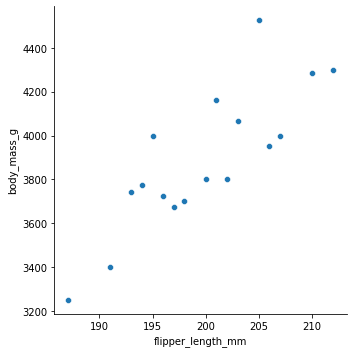

In [8]:
sns.relplot(data=male_chinstrap, x='flipper_length_mm', y='body_mass_g')

We usually like to add a line to our data so we can see what the trend is. But which is the best line to use? A horizontal line that cuts through the average y value of our data is probably the worst fit of all. However, it gives us a good starting point for talking about how to find the optimal line to fit our data.   
We can measure how well this line fits the data by seeing how close it is to the data points. We'll start with the point in the lower left-hand corner of the graph. We can draw a line from this point up to the line that cuts across the average Y value for this data set. The **residual** is the difference beteen the actual and fitted values of the dependent variable. The term is squared to ensure that each term is positive. 
Finally we make the sum of all the squared residuals between the line and the data points. It's called the **sum of squared residuals**.  
If we would simply use the sum of the residuals, the positive residuals would cancel the negative residuals. We could also minimize the sum of the _absolute values_ of the residuals and this would be a perfectly reasonable procedure. However, for technical and historical reasons,
it is not the procedure usually chosen.

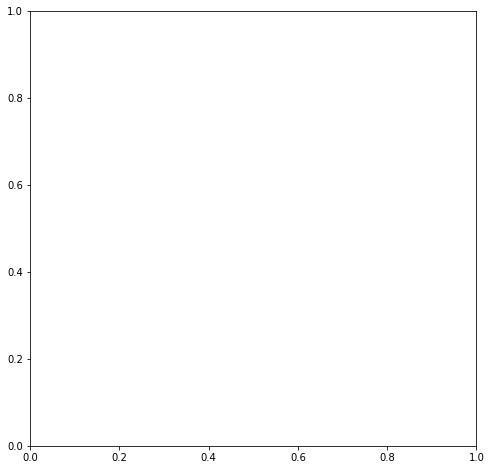

In [9]:
from matplotlib.collections import LineCollection
import math
# set the minimum and maximum value of the x- and y-axis
xmin = math.floor(male_chinstrap['flipper_length_mm'].min() / 10) * 10
xmax = math.ceil(male_chinstrap['flipper_length_mm'].max() / 10) * 10

ymin = math.floor(male_chinstrap['body_mass_g'].min() / 10) * 10
ymax = math.ceil(male_chinstrap['body_mass_g'].max() / 10) * 10

fig, axs = plt.subplots(figsize=(8, 8));


In [10]:
# Calculate the average value of body_mass_g
# y = a * x + b
a = 0
b = male_chinstrap['body_mass_g'].mean()


In [11]:
import time

def animate(i):
  # clear everything
  axs.clear()

  # set axs 
  axs.set_xlim([xmin, xmax])
  axs.set_ylim([ymin, ymax])

  # draw points
  for l in range(len(male_chinstrap)): 
    axs.plot(male_chinstrap.iloc[l, 0], male_chinstrap.iloc[l, 1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")    
    
  if i > 0:
    # draw the line (ax + b)
    x_values = [xmin + 2, xmax - 2]
    y_values = [a * x_values[0] + b, a * x_values[1] + b]
    axs.plot(x_values, y_values, lw = 3)

  if i > 1:   
    # add the residuals segments
    segs = []
    sum_squared_residuals = 0
    for q in range(i - 1):
      # calculate the sum of the squared residuals
      sum_squared_residuals +=  ((a * male_chinstrap.iloc[q, 0] +  b) - male_chinstrap.iloc[q, 1]) ** 2 
      segs.append([(male_chinstrap.iloc[q, 0], a  * male_chinstrap.iloc[q, 0] +  b),(male_chinstrap.iloc[q, 0], male_chinstrap.iloc[q, 1])])
    lc = LineCollection(segs, linewidths=1, colors='g', linestyle='dashed')
    axs.add_collection(lc)


    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    axs.text(0.05, 0.95, f'Sum Squared Residuals = {sum_squared_residuals:5.2e}', transform=axs.transAxes, fontsize=14, verticalalignment='top', bbox=props)


In [12]:
from matplotlib import rc
rc('animation', html='jshtml')

In [13]:
from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, animate, frames=[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18, 18], interval=1000, repeat=False)

In [14]:
anim

Now we want to find out how good the fit is if we rotate the line a little bit.
We'll calculate the values for the following values for a and b in y = ax + b. 
a is the slope of the line and b is the intercept of the line. That's the location on the Y axis that the line crosses when X equals 0.   
We want to find out if the sum of the squared residuals improves (i.e. the value goes odwn) if we rotate the line a little bit more or if we rotate a whole lot.  
We get the following results:  
`a = 37 and b = -3385	=> sum_squared_residuals = 763913.0`  
`a = 23 and b = -820	=> sum_squared_residuals = 943627.99`  
`a = 23 and b = -715	=> sum_squared_residuals = 719312.99`  
`a = 20.5 and b = -92	=> sum_squared_residuals = 999596.58`  
`a = 29 and b = -1635	=> sum_squared_residuals = 1827563.66`

In [15]:
a_values = [37, 23, 23, 20.5, 29]
b_values = [-3385, -820, -715, -92, -1635]

In [16]:
import time

def animate(i):
  len_male_chinstrap_plus_2 = len(male_chinstrap) + 2

  j = i // len_male_chinstrap_plus_2
  k = i % len_male_chinstrap_plus_2

  # alles leegmaken
  axs.clear()

  # axs instellen
  axs.set_xlim([xmin, xmax])
  axs.set_ylim([ymin, ymax])

  # punten tekenen
  for l in range(len(male_chinstrap)): 
    axs.plot(male_chinstrap.iloc[l, 0], male_chinstrap.iloc[l, 1], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")    
    

  if (k == 0):  
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs.text(0.05, 0.95, f'Attempt n° {j + 1}', transform=axs.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    print()


  if k > 0:
    # rechte tekenen
    x_values = [xmin + 2, xmax - 2]
    y_values = [a_values[j] * x_values[0] +  b_values[j], a_values[j] * x_values[1] + b_values[j]]
    axs.plot(x_values, y_values, lw = 3)

  if k > 1:   
    # lijn segmenten toevoegen
    segs = []
    sum_squared_residuals = 0
    for q in range(k - 1):
      sum_squared_residuals +=  ((a_values[j] * male_chinstrap.iloc[q, 0] +  b_values[j]) - male_chinstrap.iloc[q, 1]) ** 2 
      segs.append([(male_chinstrap.iloc[q, 0], a_values[j]  * male_chinstrap.iloc[q, 0] +  b_values[j]),(male_chinstrap.iloc[q, 0], male_chinstrap.iloc[q, 1])])
    lc = LineCollection(segs, linewidths=1, colors='g', linestyle='dashed')
    axs.add_collection(lc)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    axs.text(0.05, 0.95, f'Sum Squared Residuals = {sum_squared_residuals:5.2e}', transform=axs.transAxes, fontsize=14, verticalalignment='top', bbox=props)



In [17]:
# calculating the frames needed
len_male_chinstrap_plus_2 = len(male_chinstrap) + 2

frames = []
for i in range(len(a_values)):
  frames.append(i * len_male_chinstrap_plus_2)
  frames.append(i * len_male_chinstrap_plus_2)
  frames.append(i * len_male_chinstrap_plus_2 + 1)
  frames.append(i * len_male_chinstrap_plus_2 + 1)
  for j in range(len(male_chinstrap)):
    frames.append(i * len_male_chinstrap_plus_2 + 2 + j)
  frames.append(i * len_male_chinstrap_plus_2 + 2 + j)
  frames.append(i * len_male_chinstrap_plus_2 + 2 + j)

anim = FuncAnimation(fig, animate, frames=frames, interval=1000, repeat=False)

In [18]:
anim

### Method of least squares

The **least squares line** is the line that minimizes the sum of the squared residuals.

The minimization problem itself is a calculus problem, but in essence we want to approximate a collection of points $(x_i, y_i)$ (with $i: 1, \ldots, n$) as closely as possible with a line $\hat{y} = \beta_0 + \beta_1 x$. The notation $\hat{y}$ stands for "an estimation for $y$". Parameters $\beta_0$ (intercept with the Y axis) and $\beta_1$ (slope) are calculated as follows:


$\beta_1 = \frac{\sum_{i=1}^{n}(x_i - \overline{x})(y_i - \overline{y})}{\sum_{i=1}^{n}(x_i - x)^2}$

$\beta_0 = \overline{y} - \beta_1 \overline{x}$

These values for $\beta_0$ and $\beta_1$ will minimize the sum of the squared residuals between the observed and the fitted values (hence the name of the "method of least squares"). The proof to obtain these values is beyond the scope of this course.

We can calculate $\beta_0$ and $\beta_1$ in Python as follows:

In [19]:
mx = male_chinstrap.flipper_length_mm.mean()
my = male_chinstrap.body_mass_g.mean()
xx = male_chinstrap.flipper_length_mm - mx
yy = male_chinstrap.body_mass_g - my
beta1 = sum(xx * yy) / sum(xx ** 2)
beta0 = my - beta1 * mx

# Regression line equation
print(f"ŷ = {beta0} + {beta1} x")

ŷ = -3868.3320373250367 + 38.83229652669776 x


Let's check if the values for $\beta_0$ and $\beta_1$ provide a good approximation of the observed data:

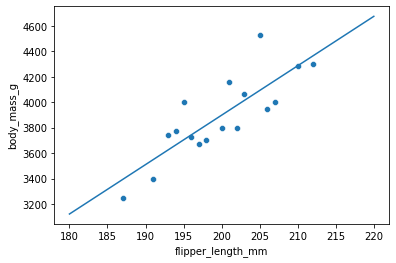

In [20]:
x_values = [xmin, xmax]
y_values = [beta1 * x_values[0] + beta0, beta1 * x_values[1] + beta0]

sns.lineplot(x=x_values, y=y_values)
sns.scatterplot(x=male_chinstrap.flipper_length_mm, y=male_chinstrap.body_mass_g)


You can plot a data set **with its regression line** as follows:

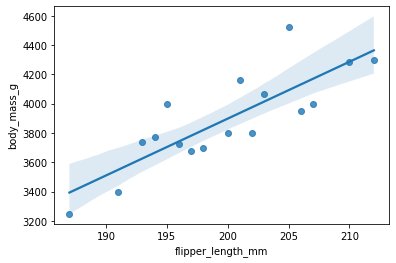

In [21]:
sns.regplot(x=male_chinstrap.flipper_length_mm, y=male_chinstrap.body_mass_g)

The regression line corresponds with the one we drew using the calculated parameters!  

The formulas for the slope and intercept in simple linear regression, are rather for conceptual purposes. Virtually all statistical software packages perform this minimization automatically.

E.g. the Python library **scikit-learn** has code to calculate a linear regression model from a set of observations.

We can then create an instance of the class LinearRegression and pass the X- and Y-values to be fitted. The array with X-values must be first converted in a 2D array.

In [22]:
from sklearn.linear_model import LinearRegression

male_chinstrap_x = male_chinstrap.flipper_length_mm.values.reshape(-1,1)
male_chinstrap_y = male_chinstrap.body_mass_g

weight_model = LinearRegression().fit(male_chinstrap_x, male_chinstrap_y)

print(f"Regression line: ŷ = {weight_model.intercept_} + {weight_model.coef_[0]} x")

Regression line: ŷ = -3868.3320373250385 + 38.83229652669777 x


## Covariance

Covariance and correlation (see next section) involve _two_ variables.
Specifically, each measures the strength and direction of a linear relationship between two
numerical variables. Intuitively, the relationship is "strong" if the points in a scatterplot
cluster tightly around some straight line. If this straight line rises from left to right, the relationship
is positive and the measures will be positive numbers. If it falls from left to right,
the relationship is negative and the measures will be negative numbers.

We'll define a `DataFrame` with the data used in the lecture slides:

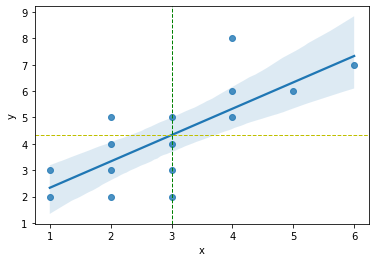

In [23]:
families = pd.DataFrame(data={
    'x': [1,1,2,2,2,2,3,3,3,3,4,4,4,5,6],
    'y': [2,3,2,3,4,5,2,3,4,5,5,6,8,6,7]
})

sns.regplot(x=families.x, y=families.y) # data set with its regression line
plt.axvline(families.x.mean(), lw=1, color='g', linestyle='dashed')  # Plot mean of x
plt.axhline(families.y.mean(), lw=1, color='y', linestyle='dashed')  # Plot mean of y

Covariance is defined as: $Cov(X,Y) = \frac{1}{n-1}\sum_{i=1}^n(x_i - \overline{x})(y_i - \overline{y})$

Covariance is essentially an average of products of deviations from means. If _X_ and _Y_ vary in the same direction, then when _X_ is above its mean, _Y_ will tend to be above its mean, and when _X_ is below its mean,
_Y_ will tend to be below its mean. In either case, the product of deviations will be positive—
a positive times a positive or a negative times a negative—so the covariance will be positive.
The opposite is true when _X_ and _Y_ vary in opposite directions. Then the covariance
will be negative.

In [24]:
mx = families.x.mean()
my = families.y.mean()

covar = sum((families.x - mx) * (families.y - my)) / (len(families.x) - 1)
print(f"Cov(x,y) = {covar}")

Cov(x,y) = 2.0


To calculate covariance, you can use the Numpy function `cov`. It's a bit complicated to use, because it returns not a single value, but a covariance matrix:

```
cov(a,a)  cov(a,b)
cov(b,a)  cov(b,b)
```

Remark that the definition of `cov(a,a)` reduces to the variance of `a`!

We can extract the value we need with:

In [25]:
np.cov(families.x, families.y, ddof=1)[0][1]

2.0

Remark that we use the parameter `ddof=1` for an unbiased estimate from the sample!



Covariance has a serious limitation as a descriptive measure because it is very sensitive
to the units in which X and Y are measured. For example, if _X_ is the height of a person and _Y_ is the weight of a person, the covariance can be inflated
by a factor of 100 simply by measuring _X_ in centimeters instead of meters. This
limits the usefulness of covariance as a descriptive measure

### Pearson's product-moment correlation coefficient

Correlation (or, specifically, Pearson's product-moment correlation coefficient) is defined as:

$R = \frac{Cov(X,Y)}{\sigma_x \sigma_y} = \frac{\sum(x_i - \overline{x})(y_i - \overline{y})}{\sqrt{\sum{(x_i-\overline{x})^2}} \sqrt{\sum{(y_i - \overline{y})^2}}}$

Correlation is a _unitless_ quantity that is unaffected by the measurement scale. For example, the correlation
is the same regardless of whether the variable _X_ (e.g. height of a person) is measured in millimeters, centimeters, decimeters or meters.

The correlation is not only unaffected by the units of measurement of the two variables, but it is always between −1 and +1. The closer it is to either of these two extremes, the closer the points in a scatterplot are to a straight line, either in the negative or positive direction.  
On the other hand, if the correlation is close to 0, the scatterplot is typically a 'cloud' of points with no apparent relationship. However, although it is not common, it is also _possible_ that the points are close to a curve and have a correlation close to 0. This is because correlation is relevant only for measuring **linear** relationships.

In [26]:
# Correlation calculated from covariance
R1 = covar / (families.x.std() * families.y.std())
print(f"R = {R1}")

R = 0.7533708035008838


In [27]:
# Correlation from elaborated formula
xx = families.x - families.x.mean()
yy = families.y - families.y.mean()
R2 = sum(xx * yy) / (np.sqrt(sum(xx ** 2) * sum(yy ** 2)))
print(f"R = {R2}")

R = 0.7533708035008839


In [28]:
# Python function numpy.corrcoef() - returns a matrix, like numpy.cov()
cor = np.corrcoef(families.x, families.y)[0][1]
print(f"R = {cor}")

R = 0.7533708035008838


### Coefficient of determination

The coefficient of determination is an estimate of the fraction of the variance in the dependent variable that is explained by the independent variable in a simple linear regression. The closer to 1, the more the variance is explained by the regression line, and the stronger the linear relation between the variables. Graphically, the higher the coefficient of determination, the closer the observations are located near the regression line.

The determination coefficient can be calculated as the square of Pearson's correlation coefficient:

In [29]:
cor ** 2

0.5675675675675673

So for this case, about 57% of the variance in the observations is explained by the regression line, which indicates a strong linear relation (see below).

The `LinearModel` class also has a method to calculate the coefficient of determination. We first need to call the `fit()` method and then we can use the method `score()` that returns $R^2$

In [30]:
familiesx = families.x.values.reshape(-1,1)
familiesy = families.y

families_model = LinearRegression().fit(familiesx, familiesy)
families_model.score(familiesx, familiesy)

0.5675675675675678

### Interpretation of R and R²

Depending on the value of $|R|$ (or $R^2$), you can draw a conclusion about the strength of the linear relation between the two variables:

| $abs(R)$  |  $R^2$   | Explained variance |   Linear relation    |
| :-------: | :------: | :----------------: | :------------------: |
|   < .3    |   < .1   |       < 10%        |      very weak       |
|  .3 - .5  | .1 - .25 |     10% - 25%      |         weak         |
|  .5 - .7  | .25 - .5 |     25% - 50%      |       moderate       |
| .7 - .85  | .5 - .75 |     50% - 75%      |        strong        |
| .85 - .95 | .75 - .9 |     75% - 90%      |     very strong      |
|   > .95   |   > .9   |       > 90%        | exceptionally strong |

**Remark** that the value of $R$ doesn't say anything about the steepness of the regression line! It only indicates how close the observations are to the regression line. Therefore, it is **wrong** to say that a value of e.g. $R = 0.8$ indicates a strongly increasing linear relation! Instead, you should say it indicates an _increasing and strong linear relation_.


### Intuitive interpretation of $R$ and $R^2$ using the male chinstrap data

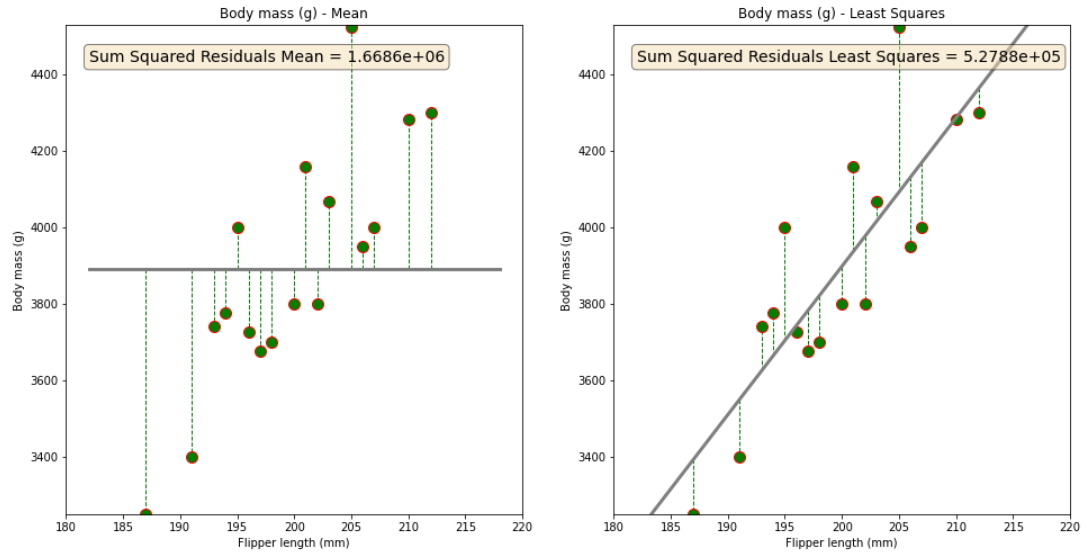

* At the left side, the horizontal line is the **mean** of the body mass. At the right side, the line shown is the **least squares line**.
*   Given that we know the flipper length of a penguin, is the mean weight the best way to predict the weight of the penguin? No, we can do way better.
*   We can predict the weight of the penguin much better using the least squares line. If we have a high value (e.g. 215)  for the flipper length, we can take a look at the least squares line (at the right side) and make a good guess about the weight.
*   Does the right (least squares) line fit the data better than the left (mean) line? And if so, how much better?
*   By eye, it looks like the right (least squares) line fits the data better than the left (mean) line.
* How do we quantify that difference? **$R^2$**
* **$R^2$** = $\frac{(Sum\ Squared\ Residuals\ Mean) - (Sum\ Squared\ Residuals\ Least\ Squares)}{(Sum\ Squared\ Residuals\ Mean)}$
* Because of the denominator $R^2$ takes a value in a range from 0 to 1 because the sum of the squared residuals around the mean will never be greater than the sum of the squared residuals around the least squares line. 



In [33]:
# Calculation of R² using score() of LinearModel()

male_chinstrap_x = male_chinstrap.flipper_length_mm.values.reshape(-1,1)
male_chinstrap_y = male_chinstrap.body_mass_g

male_chinstrap_model = LinearRegression().fit(male_chinstrap_x, male_chinstrap_y)
male_chinstrap_model.score(male_chinstrap_x, male_chinstrap_y)


0.6836386990302872

In [34]:
# Calculation of R² (based on the image above)

(1.6686 * 10**6 - 5.2788 * 10**5) / (1.6686 * 10**6)

0.6836389787846099

* There is 68% less variation around the least squares line than the mean line. Or, in other words, the flipper_length vs. body_mass relationship accounts for 68% of the variation.
* So, when someone says ... "The statistically significant R² is 0.9 ..." => You can think to yourself: "Very good! The relationship between the 2 variables explains 90% of the variation in the data!"
* How is R related to R²?
* So, when someone says ... "The statistically significant R is 0.9 ..." => You can think to yourself: "0.9 * 0.9 = 0.81. Very good! The relationship between the 2 variables explains 81% of the variation in the data!"
* R² is easier to interpret than R.
* How much better is R = 0.7 than R = 0.5?  
R² = 0.7 * 0.7 ~ 0.5 => 50% of the original variation in explained  
R² = 0.5 * 0.5 = 0.25 => 25% of the original variation in explained  
With R², it is easy to see that the first correlation is twice as good as the second.

